In [1]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import pickle

# Add the path to the library folder
sys.path.append('./lib')

from model import PDFmodel

In [2]:
seed = 12312

In [3]:
# Load data
fk_grid = np.load('Tommaso/fk_grid.npy')
real_data = np.load('Tommaso/data.npy')
FK = np.load('Tommaso/FK.npy')
f_bcdms = np.load('Tommaso/f_bcdms.npy')
Cy = np.load('Tommaso/Cy.npy')
Cinv = np.linalg.inv(Cy)
data = FK @ f_bcdms

In [4]:
models, steps = pickle.load(open("./training_2025-04-09_10-49-15.pkl", "rb"))

In [187]:
# Generate model
model = PDFmodel(
        dense_layer='Dense',
        input=fk_grid,
        outputs=1,
        architecture=[28,20],
        activations=['tanh', 'tanh'],
        kernel_initializer='GlorotNormal',
        user_ki_args=None,
        seed=seed)

f0 = model.predict().numpy().reshape(-1)

# Compute ntk
#ntk = model.compute_ntk()
ntk = models[-1].compute_ntk()
ntk_0 = models[0].compute_ntk()
U, S, V = np.linalg.svd(ntk)
U_0, S_0, V_0 = np.linalg.svd(ntk_0)

In [188]:
S_0

array([2.2801791e+02, 2.7479204e+01, 2.6438316e-02, 2.6582860e-04,
       5.3330000e-06, 3.2310725e-06, 3.0083711e-06, 2.8315083e-06,
       2.5409922e-06, 2.5045922e-06, 2.4943872e-06, 2.4032722e-06,
       2.2643726e-06, 2.1800117e-06, 1.9806571e-06, 1.9070628e-06,
       1.8850036e-06, 1.8394327e-06, 1.6634717e-06, 1.6202071e-06,
       1.5720002e-06, 1.5331236e-06, 1.4318837e-06, 1.4113405e-06,
       1.3206817e-06, 1.2340203e-06, 1.1718447e-06, 1.1168431e-06,
       1.0882806e-06, 9.4224862e-07, 9.3311957e-07, 8.8989066e-07,
       7.2836588e-07, 7.1357550e-07, 6.4065256e-07, 6.1684665e-07,
       4.9951524e-07, 4.5075697e-07, 4.1563689e-07, 3.6337360e-07,
       3.0162522e-07, 1.9201920e-07, 1.8321138e-07, 1.7794916e-07,
       1.5267480e-07, 8.3101796e-08, 7.1808714e-08, 3.6459376e-08,
       2.4252820e-08, 1.7535606e-09], dtype=float32)

In [186]:
S

array([1.7705540e+02, 7.1807228e+01, 3.4095006e+00, 1.2917563e+00,
       5.5792227e-02, 6.4316550e-03, 2.9226011e-04, 8.8227116e-06,
       2.8669645e-06, 2.5318429e-06, 2.3987186e-06, 2.3858724e-06,
       2.1634553e-06, 2.1140906e-06, 2.0778164e-06, 1.9372183e-06,
       1.9329739e-06, 1.8105777e-06, 1.8048270e-06, 1.7196797e-06,
       1.6575807e-06, 1.6194629e-06, 1.5270986e-06, 1.4817077e-06,
       1.3875855e-06, 1.3460026e-06, 1.3161849e-06, 1.1955593e-06,
       1.1819216e-06, 1.0891794e-06, 1.0519764e-06, 9.5019840e-07,
       8.9217400e-07, 7.9184736e-07, 7.6754168e-07, 7.3579224e-07,
       6.1262261e-07, 6.1011104e-07, 5.4783419e-07, 5.4077196e-07,
       5.1593878e-07, 3.8920825e-07, 3.3144502e-07, 2.9433923e-07,
       2.3097722e-07, 2.1041724e-07, 1.4802954e-07, 9.7840292e-08,
       4.8452669e-08, 3.7318561e-08], dtype=float32)

In [157]:
reg1 = 0#1e2 # Integrability
reg2 = 0#1e2 # At one
reg3 = 0 # At zero
mat_reg_2 = np.zeros((FK.shape[1], FK.shape[1]))
mat_reg_3 = np.zeros((FK.shape[1], FK.shape[1]))
mat_reg_2[-1,-1] = 1
mat_reg_3[0,0] = 1
M = FK.T @ Cinv @ FK + reg1 * np.eye(FK.shape[1]) + reg2 * mat_reg_2 + reg3 * mat_reg_3
U_M, sigma, Vh_M = np.linalg.svd(M, hermitian=True)

In [158]:
for r_idx in range(U_M.shape[0]):
  if not np.allclose(U_M[:,r_idx], Vh_M.T[:,r_idx]):
    print(f"Noise at {r_idx}")

Noise at 22
Noise at 23
Noise at 24
Noise at 25
Noise at 26
Noise at 27
Noise at 28
Noise at 29
Noise at 30
Noise at 31
Noise at 32
Noise at 33
Noise at 34
Noise at 35
Noise at 36
Noise at 37
Noise at 38
Noise at 39
Noise at 40
Noise at 41
Noise at 42
Noise at 43
Noise at 44
Noise at 45
Noise at 46
Noise at 47
Noise at 48
Noise at 49


In [159]:
r = 20 # Number of singular values to keep
print(np.allclose(U_M[:,r-1], Vh_M.T[:,r-1]))
u = U_M
u_tilde = u @ np.diag(np.sqrt(sigma))

True


In [160]:
H_tilde = np.zeros((r,r))
for i in range(r):
    for j in range(r):
        H_tilde[i,j] = np.dot(u_tilde[:,i], ntk.numpy() @ u_tilde[:,j])

U_h_tilde, h, Vh_h_tilde = np.linalg.svd(H_tilde, hermitian=True)

In [161]:
for l_idx in range(U_h_tilde.shape[0]):
  if not np.allclose(U_h_tilde[:,l_idx], Vh_h_tilde.T[:,l_idx]):
    print(f"Noise at {l_idx + 1}")

Noise at 9
Noise at 11
Noise at 14
Noise at 16
Noise at 17
Noise at 19


In [176]:
l = 5 # Number of singular values to keep
print(np.allclose(U_h_tilde[:, l-1], Vh_h_tilde.T[:, l-1]))
z = U_h_tilde

True


In [177]:
b = ntk.numpy() @ FK.T @ Cinv @ data
b_tilde = np.array([np.dot(u[:, i], b) for i in range(r)])
B = np.array([np.dot(z[:,n], b_tilde) for n in range(l)])

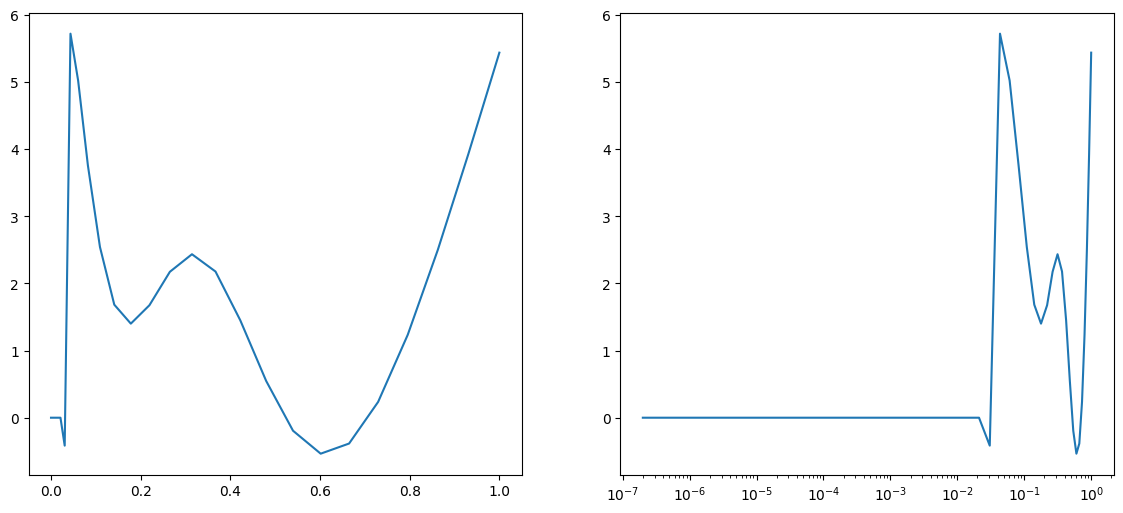

In [178]:
inf_res = [B[n] / h[n] for n in range(l)]
inf_tilde = np.sum([z[:,n] * inf_res[n] for n in range(l)], axis=0)
f_inf = np.sum([inf_tilde[i] * u_tilde[:,i] / sigma[i] for i in range(r)], axis=0)

fig, axs = plt.subplots(1,2, figsize=(14, 6))
axs[0].plot(fk_grid, f_inf)
axs[1].plot(fk_grid, f_inf)
axs[1].set_xscale('log')

In [179]:
f0_tilde = np.array([np.dot(u_tilde[:,i], f0) for i in range(r)])
F0 = np.array([np.dot(z[:,n], f0_tilde) for n in range(l)])

def Ft(t):
  ret = [
    np.exp(-h[n] * t) * F0[n] +
    ( 1 - np.exp(-h[n] * t) ) * B[n] / h[n]
    for n in range(l)
  ]
  return np.array(ret)

def ft_tilde(t):
  F = Ft(t)
  ret = [F[n] * z[:,n] for n in range(l)]
  return np.sum(ret, axis=0)

def ft(t):
  f_tilde = ft_tilde(t)
  ret = [f_tilde[i] * u_tilde[:,i] / sigma[i] for i in range(r)]
  return np.sum(ret, axis=0)

In [180]:
f0_tilde = np.array([np.dot(u_tilde[:,i], f0) for i in range(r)])
f0_rec = [f0_tilde[i] * u_tilde[:,i] / sigma[i] for i in range(r)]
f0_rec = np.sum(f0_rec, axis=0)

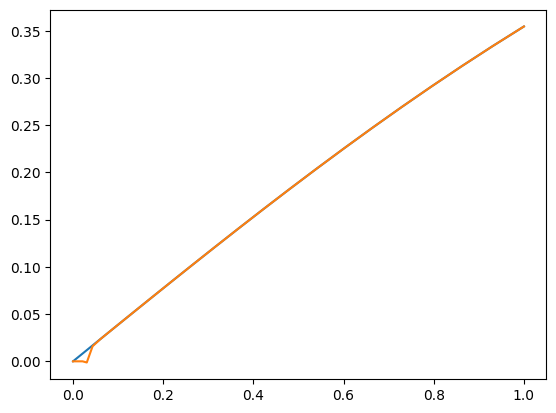

In [181]:
plt.plot(fk_grid, f0, label='f0')
plt.plot(fk_grid, f0_rec, label='ft(0)')
#plt.xscale('log')

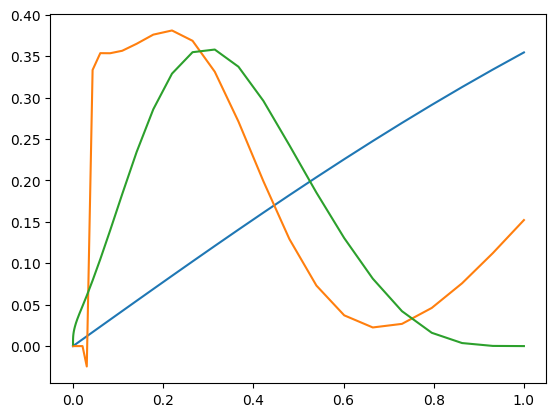

In [182]:
plt.plot(fk_grid, f0, label='f0')
plt.plot(fk_grid, ft(6e-4), label='ft(0)')
plt.plot(fk_grid, f_bcdms)
#plt.xscale('log')

# 